In [38]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as sc
from scipy.optimize import curve_fit

sns.set_theme(font_scale=1.7, style='whitegrid') 

In [2]:
u_samp = np.loadtxt("Results/uniform_sampling.dat")
i_samp = np.loadtxt("Results/importance_sampling.dat")
dis_rw = np.loadtxt("Results/discrete_RW.dat")
con_rw = np.loadtxt("Results/continuum_RW.dat")
block_disc = np.loadtxt("Results/block_on_steps_disc.dat")
block_cont = np.loadtxt("Results/block_on_steps_cont.dat")

In [3]:
len(dis_rw)

100

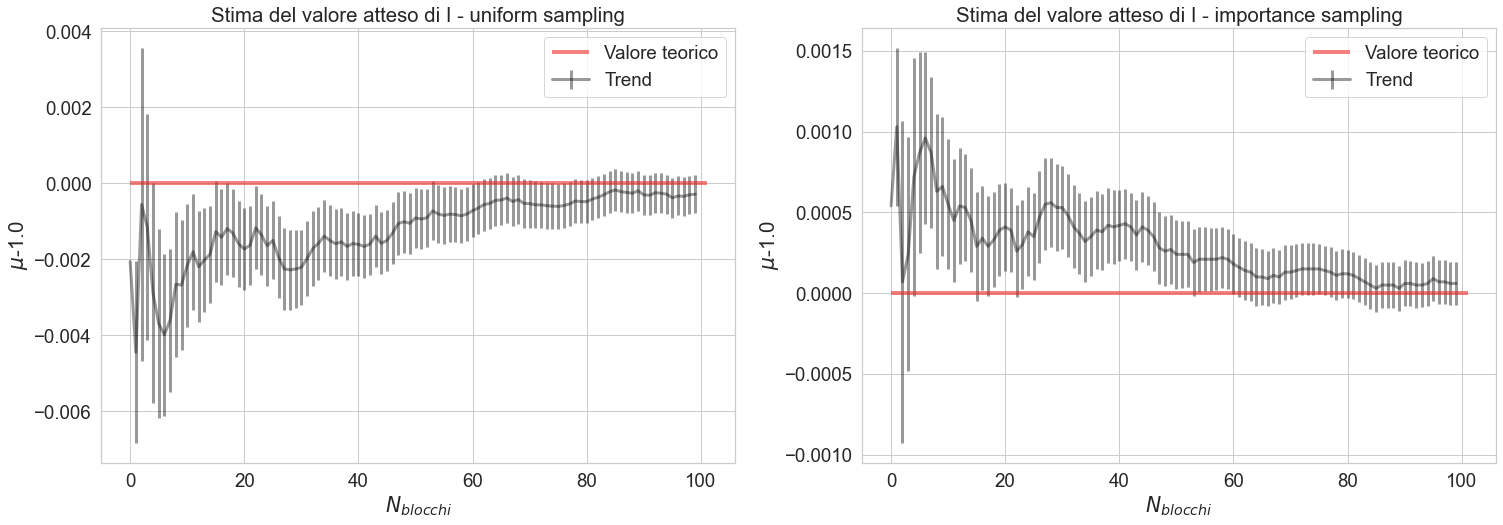

In [4]:
x = np.arange(100)

plt.figure(figsize=(25,8))

plt.subplot(1,2,1)
plt.title("Stima del valore atteso di I - uniform sampling")
plt.errorbar(x, u_samp.T[0]-1, yerr=u_samp.T[1], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(0,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel("$\mu$-1.0")
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.subplot(1,2,2)
plt.title("Stima del valore atteso di I - importance sampling")
plt.errorbar(x, i_samp.T[0]-1, yerr=i_samp.T[1], color='black', alpha=0.4, label='Trend', linewidth=3)
plt.hlines(0,0,101, color='#EE2C2C', linestyle='-', label="Valore teorico", linewidth=4, alpha=0.6)
plt.ylabel("$\mu$-1.0")
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.show()

In [5]:
y = np.linspace(0,1)
f = np.pi/2 * np.cos(np.pi/2 *y)
g = -2*y+2

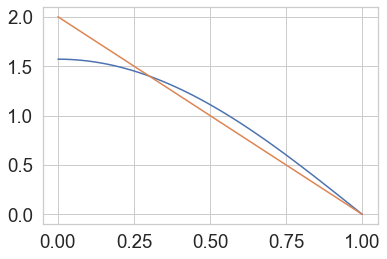

In [6]:
plt.plot(y, f)
plt.plot(y, g)

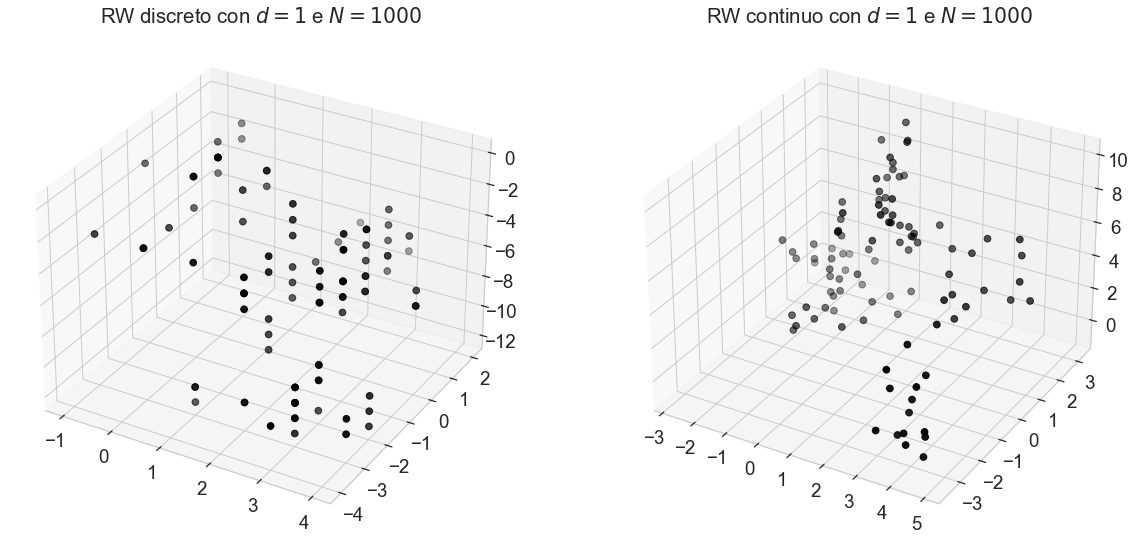

In [7]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,2,1, projection='3d')
plt.title('RW discreto con $d=1$ e $N=1000$')
ax.scatter(dis_rw.T[0], dis_rw.T[1], dis_rw.T[2], color='black', s=45)

ax1 = fig.add_subplot(1,2,2, projection='3d')
plt.title('RW continuo con $d=1$ e $N=1000$')
ax1.scatter(con_rw.T[0], con_rw.T[1], con_rw.T[2], color='black', s=45)
plt.show()

In [39]:
def sqrt_fit(N,k):
    return K*np.sqrt(N)

In [46]:
x = np.arange(100)
y = block_disc.T[0]
z = block_cont.T[0]

popt, pcov = curve_fit(sqrt_fit, x, y)
popt2, pcov2 = curve_fit(sqrt_fit, x, z)

y_pred = sqrt_fit(x, *popt)
z_pred = sqrt_fit(z, *popt2)

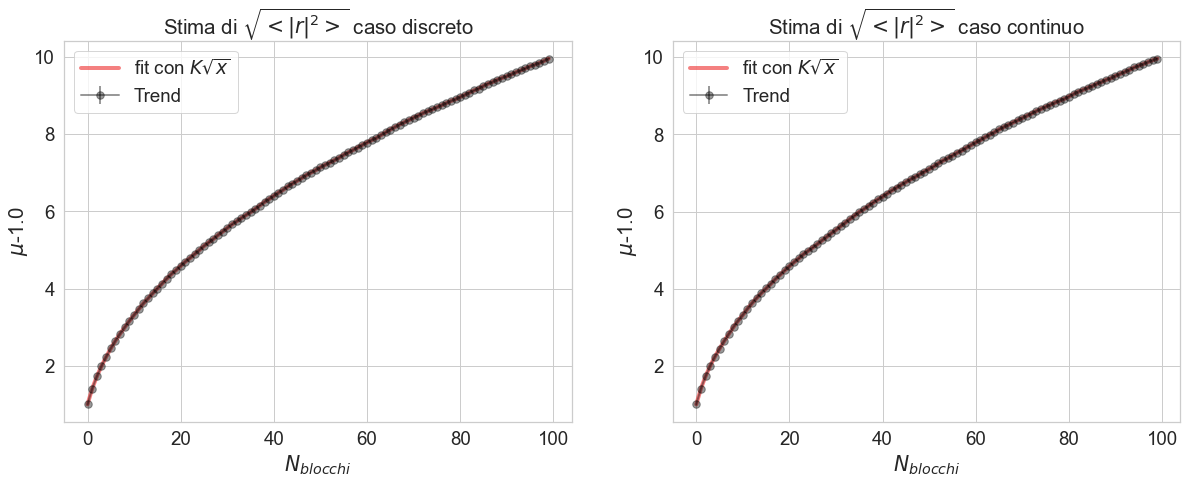

In [47]:
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.title("Stima di $\sqrt{<|r|^2>}$ caso discreto")
plt.errorbar(x, block_disc.T[0], yerr=block_disc.T[1], color='black', alpha=0.4, label='Trend', linewidth=2, markersize=15,marker='.')
plt.plot(x, y, color='#EE2C2C', linestyle='-', label="fit con $K\sqrt{x}$", linewidth=4, alpha=0.6)
plt.ylabel("$\mu$-1.0")
plt.xlabel("$N_{blocchi}$")
plt.legend()

plt.subplot(1,2,2)
plt.title("Stima di $\sqrt{<|r|^2>}$ caso continuo")
plt.errorbar(x, block_cont.T[0], yerr=block_cont.T[1], color='black', alpha=0.4, label='Trend', linewidth=2, markersize=15,marker='.')
plt.plot(x, z, color='#EE2C2C', linestyle='-', label="fit con $K\sqrt{x}$", linewidth=4, alpha=0.6)
plt.ylabel("$\mu$-1.0")
plt.xlabel("$N_{blocchi}$")
plt.legend()
plt.show()